# Predicting Loan Repayment with Call Logs

This notebook predicts loan repayment given call logs.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, \
    RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, \
    f1_score, make_scorer

/Users/victoria/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load Data
Read in the data and perform basic metadata analysis.
Check the columns for missing data.

In [2]:
repayment = pd.read_csv(
    "~/Downloads/DataScienceChallengeData/"
    "dataScienceChallenge_repayment.csv")
call_log = pd.read_csv(
    "~/Downloads/DataScienceChallengeData/"
    "dataScienceChallenge_calllog.csv")

In [3]:
print(f"Repayment sum of null values:\n{35 * '-'}")
print(f"{repayment.isnull().sum()}\n")
print(f"Call log sum of null values:\n{35 * '-'}")
print(f"{call_log.isnull().sum()}")

Repayment sum of null values:
-----------------------------------
person_id_random     0
signup_date          0
disbursement_date    0
paid_first_loan      0
dtype: int64

Call log sum of null values:
-----------------------------------
person_id_random              0
phone_randomized              0
contact_name_redacted    276676
direction                     0
duration                      0
local_timestamp               0
dtype: int64


There are no null values, except contact name.

In [4]:
print(
    f"Repayment sum of unique ids: {repayment['person_id_random'].nunique()}")
print(
    f"Call log sum of unique ids: {call_log['person_id_random'].nunique()}")

Repayment sum of unique ids: 1250
Call log sum of unique ids: 1216


Id's are unique in repayment data, but not every repayment id has a call log entry. 

## Feature Exploration and Engineering
I hypothesized that better borrowers may:
* Make more calls than they receive
* Have fewer missed calls
* Make longer calls
* Use more peak minutes
* Have more contacts

Based on this, I chose a small set of features that I thought would have the greatest impact on the model. 
* Out-in-ratio - the ratio of outgoing to incoming calls. This represents people reaching out to their network more.
* Sum duration - sum of call duration. This represents someone has more disposable income to spend on a phone plan. 
* Percent peak duration - the sum of duration that happened between peak hours. Similar to the above, this represents someone has more disposable income. 
* Minimum number of contacts - the minimum number of people in contact. This represents the size of someone’s social network. Without full phone numbers, we couldn’t get the exact count of contacts, so it was approximated using the redacted strings. This will undercount the true value. 
* Percent missed calls - the percentage of calls that were missed. This represents someone’s responsiveness.

Other interesting features we could explore in the future:
* Area code - Area codes may represent characteristics of local populations such as their relative affluence. 
* Disbursement date  -  Both signup date and disbursement date were present in the data, making it possible to use the time features to represent seasonality or even the difference between signup date and disbursement date.
* Contact name - Given the full contact name we could mine patterns such as the level of contact specificity e.g. full name vs. first name only. 
* Phone numbers - Given the full phone numbers we could also identify connections between people. For example, we may have higher confidence in someone who is connected to a successful borrower. We could also get a true value for the number of contacts.


In [5]:
call_features = pd.DataFrame()

### Duration


In [6]:
for i in call_log["direction"].unique():
    print(f"Minimum duration of {i}: {min( \
        call_log.loc[call_log['direction']==i]['duration'])}")
    print(f"Maximum duration of {i}: {max( \
        call_log.loc[call_log['direction']==i]['duration'])}\n")

Minimum duration of outgoing: 0
Maximum duration of outgoing: 128128

Minimum duration of incoming: 0
Maximum duration of incoming: 6465

Minimum duration of missed: -1
Maximum duration of missed: 72

Minimum duration of unknown: 0
Maximum duration of unknown: 0



Unknown calls always have zero duration, but missed calls can have a duration.

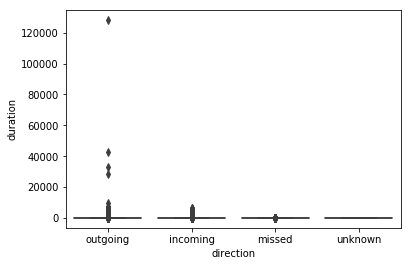

In [7]:
sns.boxplot(x=call_log["direction"], y=call_log["duration"])

Outgoing calls has outliers.

In [8]:
made_calls = call_log.loc[call_log["direction"]!="missed"]
call_features["sum_duration"] = made_calls.groupby(
    "person_id_random")["duration"].sum()

### Direction

In [9]:
 print(f"Values of direction: {call_log['direction'].unique()}")

Values of direction: ['outgoing' 'incoming' 'missed' 'unknown']


In [10]:
outgoing = call_log[call_log["direction"]=="outgoing"]
incoming = call_log[call_log["direction"]=="incoming"]
missed = call_log[call_log["direction"]=="missed"]

call_features["sum_outgoing"] = outgoing.groupby(
    "person_id_random")["direction"].count()
call_features["sum_incoming"] = incoming.groupby(
    "person_id_random")["direction"].count()
call_features["sum_missed"] = missed.groupby(
    "person_id_random")["direction"].count()
call_features["sum_calls"] = call_log.groupby(
    "person_id_random")["direction"].count()

call_features["sum_outgoing"].fillna(0, inplace=True)  
call_features["sum_incoming"].fillna(1, inplace=True) 
call_features["sum_missed"].fillna(0, inplace=True)

call_features["pct_missed"] = call_features["sum_missed"]/ \
    call_features["sum_calls"]
call_features["out_in_ratio"] = call_features["sum_outgoing"]/ \
    call_features["sum_incoming"]

call_features.drop(
    columns=["sum_outgoing", 
             "sum_incoming", 
             "sum_missed", 
             "sum_calls"],
    inplace=True)

### Timestamp

In [11]:
call_log["local_timestamp"] = pd.to_datetime(
    call_log["local_timestamp"])

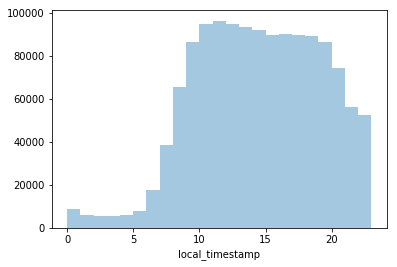

In [12]:
sns.distplot(call_log["local_timestamp"].dt.hour, 
             kde=False,
             bins=np.arange(0, 24))

In [13]:
peak_call_log = call_log.loc[call_log["local_timestamp"].dt.hour.isin(
    range(8, 21))]

sum_peak_duration = peak_call_log.groupby(
    "person_id_random")["duration"].sum()

call_features["pct_peak"] = sum_peak_duration/ \
    call_features["sum_duration"]

### Contact Name

We don't have exact contact names, but can still approximate the number of contacts by taking the unique values of the redacted name. Because there will be some overlap, we'll call this the minimum number of contacts, meaning they have at least that many, maybe more. 

In [14]:
call_features["min_num_contacts"] = call_log.groupby(
    "person_id_random")["contact_name_redacted"].nunique()

## Predictive Modeling

We need to merge the features back to the repayment data and drop any columns we didn't engineer. Then check again for any null or infinity values.

I chose a random forest because it has several nice features that work well with our data. 
* Resistant to outliers - tree-based models will split data based on a threshold, so the magnitude of the value is not part of decision, just whether it is above or below the threshold. 
* Invariant to feature scale - tree-based models use splits rather than distances so it is not necessary to standardize features. However there is some bias in the resultant feature importances. 
* Has features to handle imbalanced data - trees are sensitive to class imbalance, but you can use class weights during training to increase the weight of errors for the minority class, and/or you can use a higher threshold to account for the risks associated with underpredicting defaults. I used class weights because although it decreases the overall model accuracy, it improved the recall of defaults. 

In the future we could compare multiple algorithms.


In [15]:
call_features.reset_index(inplace=True)

data = pd.merge(repayment, 
                call_features, 
                how = "inner", 
                on = "person_id_random")

data.drop(
    columns=["signup_date", "disbursement_date", "person_id_random"], 
    inplace=True)

In [16]:
print(f"Sum of null values:\n{35 * '-'}")
print(f"{data.isnull().sum()}")

Sum of null values:
-----------------------------------
paid_first_loan     0
sum_duration        0
pct_missed          0
out_in_ratio        0
pct_peak            0
min_num_contacts    0
dtype: int64


In [17]:
print(f"Sum of infinite values:\n{35 * '-'}")
print(f"{np.isinf(data).sum()}")

Sum of infinite values:
-----------------------------------
paid_first_loan     0
sum_duration        0
pct_missed          0
out_in_ratio        0
pct_peak            0
min_num_contacts    0
dtype: int64


In [18]:
paid_loans = len(data[data["paid_first_loan"]==1])
total_loans = len(data)
print(f"Loan Repayment Rate = {paid_loans/total_loans}")

Loan Repayment Rate = 0.8273026315789473


We have a class imbalance.

In [19]:
X = data.drop(columns=["paid_first_loan"])
y = data["paid_first_loan"]

Split the data and make a random forest classifier.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [21]:
rf = RandomForestClassifier()

Make a set of parameters to search and a custom scorer.

In [22]:
params = {
    "n_estimators": [int(x) for x in np.linspace(100, 2000, 100)],
    "max_features": ["auto", "sqrt"],
    "max_depth": [int(x) for x in np.linspace(10, 100, 10)],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 10, 20],
    "bootstrap": [True, False],
    "class_weight": ["balanced", None, "balanced_subsample"]
         }

f1_weighted = make_scorer(f1_score, average="weighted")

In [23]:
rf_random = RandomizedSearchCV(estimator=rf, 
                               param_distributions=params,
                               n_iter=100, 
                               cv=3, 
                               verbose=1, 
                               random_state=0,
                               n_jobs=-1,
                               scoring=f1_weighted)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/victoria/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.0s
/Users/victoria/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/victoria/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
/Users/victoria/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-d

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 119, 138, 157, 176, 195, 215, 234, 253, 272, 291, 311, 330, 349, 368, 387, 407, 426, 445, 464, 483, 503, 522, 541, 560, 579, 598, 618, 637, 656, 675, 694, 714, 733, 752, 771, 790, 810, 829, 848, 867, 886, 906, 925, 944, 963, 982, 1002, 1021, 1040, 1059, 107...: [1, 10, 20], 'bootstrap': [True, False], 'class_weight': ['balanced', None, 'balanced_subsample']},
          pre_dispatch='2*n_jobs', ra

In [24]:
rf_random.best_params_

{'n_estimators': 1808,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

Fit the best parameters.

In [25]:
rf_best_random = rf_random.best_estimator_

## Model Evaluation

After choosing the best parameters with a randomized search, I did a final model evaluation on a holdout set. 
* Weighted f1-score - used to tune the model. It combines precision and recall. When weighted, it will find the average weighted by the number of instances for each label to account for imbalanced classes.
* Precision/Recall - precision is the rate of true positives out of all predicted positives and recall is the rate of true positives out of all actual positives. We want to be able to use the predicted probability to trade-off precision and recall depending on how much risk we want in our loan portfolio, and/or to be able to set appropriate interests rates based on risk. 

The feature importance is the gini importance, it represents the reduction in uncertainty of each feature by measuring the decrease in node impurity over the all the trees. This allows us to remove any unnecessary features and get an estimation of relative importance. 


In [26]:
class_predictions = rf_best_random.predict(X_test)
print(classification_report(y_test, class_predictions))

             precision    recall  f1-score   support

          0       0.33      0.29      0.31        58
          1       0.87      0.89      0.88       307

avg / total       0.78      0.79      0.79       365



In [27]:
class_pred_df = pd.DataFrame(class_predictions, 
                             columns = ["repayment_prediction"])
loan_repayment = sum(class_pred_df["repayment_prediction"]==1)
print(f"Predicted Repayment Rate = {loan_repayment/len(class_pred_df)}")

Predicted Repayment Rate = 0.8575342465753425


The model is overpredicting loan repayment just a bit compared to the sample population.

In [28]:
pd.DataFrame(rf_best_random.feature_importances_,
             X_train.columns, 
             columns = ["importance"])

,importance
sum_duration,0.304553
pct_missed,0.153037
out_in_ratio,0.169190
pct_peak,0.152052
min_num_contacts,0.221169
